In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../../feature1.csv")
df.columns

Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
       'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
       'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
       'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
       'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id', 'MODE', 'datetime',
       'season', 'weekday', 'current', 'direction', 'pressure', 'rain',
       'snowfall', 'weathercode', 'is_weekday', 'wind_force', 'wind_direc',
       'effective_wind_factor', 'effective_wind', 'resist_ratio1',
       'resist_ratio2', 'adversarial'],
      dtype='object')

In [3]:
df["POWER"] = (df["POWER_1"]+df["POWER_2"])/2
df["SPEED"] = (df["SPEED_1"]+df["SPEED_2"])/2
df["THRUST"] = (df["THRUST_1"]+df["THRUST_2"])/2
df["TORQUE"] = (df["TORQUE_1"]+df["TORQUE_2"])/2
df["PITCH"] = (df["PITCH_1"]+df["PITCH_2"])/2
df["resist_ratio"] = (df["resist_ratio1"]+df["resist_ratio2"])/2
df["FLOWTEMPA"] = (df["ENGINE_1_FLOWTEMPA"]+df["ENGINE_2_FLOWTEMPA"])/2
df["FC"] = (df["ENGINE_1_FUEL_CONSUMPTION"]+df["ENGINE_2_FUEL_CONSUMPTION"])/2

df = df.drop(['PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS',  'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'datetime',
       'resist_ratio1', 'resist_ratio2', 'SPEED_1', 'SPEED_2', "STW",
       'ENGINE_1_FLOWTEMPA', 'ENGINE_2_FLOWTEMPA', 
       "ENGINE_1_FUEL_CONSUMPTION", "ENGINE_2_FUEL_CONSUMPTION"], axis=1)

In [4]:
# df = df.drop(["FLOWTEMPA", "PITCH", "POWER", "THRUST"], axis=1)
# df = df.drop(["pressure"], axis=1)

<AxesSubplot:>

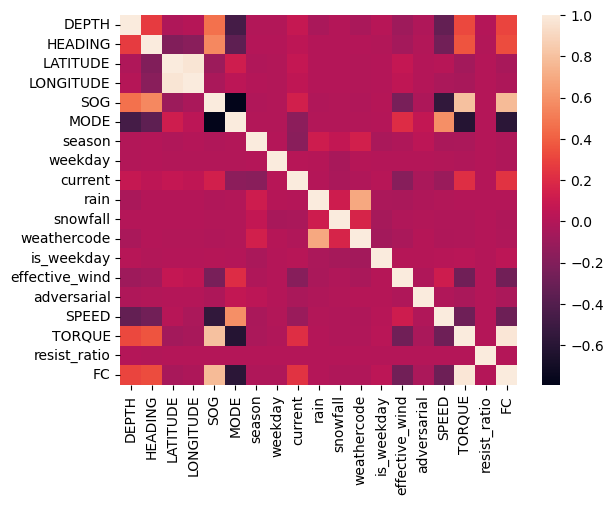

In [5]:
import seaborn as sns
sns.heatmap(df[['DEPTH', 'HEADING', 'LATITUDE', 'LONGITUDE', 'SOG',
       'MODE', 'season', 'weekday', 'current', 'direction',
       'rain', 'snowfall', 'weathercode', 'is_weekday',
        'effective_wind', 'adversarial', 
       'SPEED', 'TORQUE', 'resist_ratio',
       'FC']].corr())

In [6]:
df.columns

Index(['Dati', 'Time', 'DEPTH', 'HEADING', 'LATITUDE', 'LONGITUDE', 'SOG',
       'WIND_ANGLE', 'WIND_SPEED', 'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE',
       'trip_id', 'MODE', 'season', 'weekday', 'current', 'direction',
       'pressure', 'rain', 'snowfall', 'weathercode', 'is_weekday',
       'wind_force', 'wind_direc', 'effective_wind_factor', 'effective_wind',
       'adversarial', 'POWER', 'SPEED', 'THRUST', 'TORQUE', 'PITCH',
       'resist_ratio', 'FLOWTEMPA', 'FC'],
      dtype='object')

In [7]:
df["direction"] = df["direction"].apply(lambda x: 1 if x=="N-H" else 0)
df["MODE"] = df["MODE"].apply(lambda x: x-1)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# get one_hot for column
def one_hot(df, cols):
    for col in cols:
        dummy = pd.get_dummies(df[col],prefix=col, drop_first=True)
        df = pd.concat([df, dummy], axis=1).drop(col, axis=1)
    return df

In [9]:
# H-N
d1 = df[df.direction==1][["LONGITUDE", "LATITUDE","FC", "trip_id"]] # h-n
d2 = df[df.direction==0][["LONGITUDE", "LATITUDE","FC", "trip_id"]] # n-h

# get the avg location of the top 1 percent trip
def get_top1_location(d1):
    total = d1.trip_id.nunique() // 100
    top_1_trips = list(d1.groupby("trip_id").FC.sum().sort_values()[:total].index)
    i = top_1_trips.pop(0)
    hn_top = d1[d1.trip_id==i].reset_index(drop=True)
    if (len(hn_top) < 200):
        for j in range(200-len(hn_top)):
            hn_top = hn_top.append(hn_top.tail(1)).reset_index(drop=True)
    for i in top_1_trips:
        tmp_df2 = df[df.trip_id==i].reset_index(drop=True)
        if (len(tmp_df2) < 200):
            for j in range(200-len(tmp_df2)):
                tmp_df2 = tmp_df2.append(tmp_df2.tail(1)).reset_index(drop=True)
        hn_top["LONGITUDE"] = hn_top.LONGITUDE + tmp_df2.LONGITUDE
        hn_top["LATITUDE"] = hn_top.LATITUDE + tmp_df2.LATITUDE
    hn_top["LONGITUDE"] = hn_top["LONGITUDE"]/(len(top_1_trips)+1)
    hn_top["LATITUDE"] = hn_top["LATITUDE"]/(len(top_1_trips)+1)
    return hn_top[["LONGITUDE", "LATITUDE"]]

In [10]:
hn_top = get_top1_location(d1)
nh_top = get_top1_location(d2)

In [11]:
nh_top.head(3), hn_top.head(3)

(    LONGITUDE   LATITUDE
 0 -123.271491  49.377173
 1 -123.271345  49.378391
 2 -123.271136  49.381182,
     LONGITUDE   LATITUDE
 0 -123.955330  49.193695
 1 -123.955285  49.194635
 2 -123.955060  49.197100)

In [13]:
def get_observations(df, feature_cols = ['DEPTH', 'LATITUDE', 'LONGITUDE', 'SOG',
       'MODE', 'season', 'current', 'direction', 'rain', 'snowfall', 
       'weathercode', 'is_weekday', 'effective_wind', 'adversarial', 'resist_ratio', 
       'FC'], action_cols = ["HEADING", "TORQUE"]):

    features = df[feature_cols +["trip_id"]]
    # features = one_hot(features, ["season", "weathercode"])
    transform_cols = [ x for x in feature_cols if (x not in ["MODE", "is_weekday", "direction", "season", "weathercode"])]
    # apply minmax scaler to all non-binary numeric features columns 
    features_scaler = MinMaxScaler().fit(features[transform_cols])
    # print(features.columns)

    actions_df = df[action_cols + ["trip_id"]]
    # apply minmax scaler to action columns
    actions_scaler = MinMaxScaler().fit(actions_df.drop("trip_id", axis=1))
    
    rewards_col = ["trip_id", "LONGITUDE", "LATITUDE", "FC", "direction"]
    fc_scaler = MinMaxScaler()
    rewards_df = df[rewards_col]
    # find the destination longitude and latitude based on direction
    rewards_df["goal_long"] = rewards_df.direction.apply(lambda x: -123.2715 if x==1 else -123.9554)
    rewards_df["goal_lat"] = rewards_df.direction.apply(lambda x: 49.3771 if x==1 else 49.1936)
    # apply minmax scaler for fuel consumption to get reward 2
    rewards_df["reward2"] = - fc_scaler.fit_transform(rewards_df[["FC"]])

    dataset_list = []
    for i in list(df.trip_id.unique()):
        data_dict = {}
        # observations
        observation = features[features.trip_id==i].drop("trip_id", axis=1)
        observation[transform_cols] = features_scaler.transform(observation[transform_cols])
        observation = observation.to_numpy().astype(float)
        data_dict["observations"] = observation

        # next_observations
        observation = np.delete(observation, 0, 0)
        last = observation[-1]
        observation = np.vstack([observation, last])
        data_dict["next_observations"] = observation

        # actions 
        # print(i)
        actions = actions_df[actions_df.trip_id==i]
        actions = actions.drop("trip_id", axis=1)
        actions = actions_scaler.transform(actions)
        data_dict["actions"] = actions.astype(float)

        # rewards
        rewards = rewards_df[rewards_df.trip_id==i].reset_index()
        # reward1
        trip_len = rewards.shape[0]
        if rewards.loc[0,"direction"]==1:
            top1 = hn_top.iloc[:trip_len]
        else:
            top1 = nh_top.iloc[:trip_len]
        rewards["reward1"] = ((rewards["LONGITUDE"]-top1["LONGITUDE"])**2 + \
                             (rewards["LATITUDE"]-top1["LATITUDE"])**2 )**0.5
        # reward2
        rewards.loc[len(rewards)-1,"reward2"] = rewards.loc[len(rewards)-1,"reward2"]+1
        # reward3
        rewards["reward3"] = ((rewards["goal_long"]-rewards["LONGITUDE"])**2 + \
                             (rewards["goal_lat"]-rewards["LATITUDE"])**2 )**0.5
        data_dict["rewards"] = (rewards[["reward1","reward2", "reward3"]]).to_numpy()

        # termination
        termination = np.zeros([observation.shape[0],1])
        termination[-1,0] = 1
        data_dict["termination"] = termination

        dataset_list.append(data_dict)
    return dataset_list

In [ ]:
obs  = get_observations(df)

In [15]:
import pickle
with open('rl_data.pickle', 'wb') as handle:
    pickle.dump(obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
import pickle

with open('rl_data.pickle', 'rb') as handle:
    rl_data = pickle.load(handle)


In [29]:
for i in range(3):
    print(rl_data[0]["rewards"][:,i].mean())

0.028381731309116122
-0.6459092307999332
0.331222666771567


In [30]:
len(rl_data)

3126

In [31]:
rl_data[0]["rewards"][:, 1]

array([-0.32477592, -0.39035732, -0.42579213, -0.56514478, -0.6583309 ,
       -0.66401551, -0.70827365, -0.75224111, -0.80979118, -0.8172569 ,
       -0.81543056, -0.82135236, -0.79533254, -0.75621739, -0.7787154 ,
       -0.80651298, -0.78763404, -0.73650832, -0.71435432, -0.7217841 ,
       -0.70784864, -0.69843505, -0.67273302, -0.65082325, -0.62359279,
       -0.60398865, -0.62191101, -0.64446694, -0.63446024, -0.60712027,
       -0.5992259 , -0.63984299, -0.63154792, -0.60746674, -0.60250728,
       -0.62332307, -0.63681613, -0.6409377 , -0.65077132, -0.67331786,
       -0.69324108, -0.71193024, -0.70998947, -0.73297086, -0.77974347,
       -0.78656377, -0.78656863, -0.75756314, -0.70640914, -0.69820066,
       -0.70712774, -0.72400929, -0.7084522 , -0.70068008, -0.7520412 ,
       -0.73612451, -0.72822466, -0.71995754, -0.73457505, -0.75604706,
       -0.78550255, -0.76348125, -0.7622615 , -0.79118844, -0.81175559,
       -0.79890499, -0.76958976, -0.78047169, -0.78706956, -0.80